2. Gthich domain1 trong rater1_domain1 có ý nghĩa gì
3. domain1_score được tính kiểu gì
6. So sánh 2 metric MSE và QWK (Quadratic Weighted Kappa)
7. Tính và plot phân phối điểm của từng set một (groupby các set theo essay_set/ topic) + tính outlier

* essay_id: A unique identifier for each individual student essay
* essay_set: 1-8, an id for each set of essays
* essay: The ascii text of a student's response
* rater1_domain1: Rater 1's domain 1 score; all essays have this
* rater2_domain1: Rater 2's domain 1 score; all essays have this
* rater3_domain1: Rater 3's domain 1 score; only some essays in set 8 have this.
* domain1_score: Resolved score between the raters; all essays have this
* rater1_domain2: Rater 1's domain 2 score; only essays in set 2 have this
* rater2_domain2: Rater 2's domain 2 score; only essays in set 2 have this
* domain2_score: Resolved score between the raters; only essays in set 2 have this
* rater1_trait1 score - rater3_trait6 score: trait scores for sets 7-8

**Tính domain_score theo set**

* **Essay_set1 range(1-6)**

 domain1_score = rate1_domain1 + rate2_domain1

  If the two scores are non-adjacent, the final score is determined by an expert scorer.
If the two scores are adjacent, the final score for an item is the sum of the two scores. 

* **Essay_set2 range_domain1(1-6), range_domain2(1-4)**

  The 20% second read is for reliability analysis only. The reader 1 score is always reported as the score of record. There is no condition for a third resolution read.

  domain1_score = rate1_domain1

* **Essay_set3, 4 range(0-3)**

 domain1_score = max(rate1_domain1 , rate2_domain1)

  If Reader‐1 Score and Reader‐2 Score are exact or adjacent, adjudication by a third reader is not required. 
If Reader‐1 Score and Reader‐2 Score are not adjacent or exact, then adjudication by a third reader is required. 

  Có 1 số ngoại lệ VD rate1=rate2=2, domain=3, rate1=2, rate2=1, domain=3
  Có tổng 7 trường hợp ngoại lệ, set3:6, set4:1
* **Essay_set5,6 range(0-4)**

  For the specific set of data, if there was a difference between scorer 1 and scorer 2, the FINAL SCORE was always the higher of the two.


* **Essay_set7 range(0-15)**

  Scores summed independently for Rater_1 and Rater_2.

  Resolved Score = Rater_1 + Rater_2.

  domain1_score = rater1_domain1 + rater2_domain1 = ( rater1_trait1 + rater1_trait2 + rater1_trait3 + rater1_trait4) + (rater2_trait1 + rater2_trait2 + rater2_trait3 + rater2_trait4)


* **Essay_set8 range_rate1,2_domain(1-30), range_rate_3_domain(1-60)**

  For most essays:
= (I_R1+I_R2)  +  (O_R1+O_R2)  + (S_R1+S_R2)  +  2 (C_R1+C_R2)

  When there is Rater 3 set of scores for the essay then the Total Composite Score formula changes to:

  =  2 (I_R3) + 2 (O_R3) + 2 (S_R3) + 4 (C_R3)    or equivalently   2 (I+O+S+C) +  2 (C)
  = 2*rater1_trait1 + 2*rater1_trait2 + 2*rater1_trait5 + 4*rater1_trait6

  Note the use of only four of the six traits.   




**So sánh MSE và QWK**

1. QWK: https://www.kaggle.com/reighns/understanding-the-quadratic-weighted-kappa#Step-3:-Create-the-Expected-Matrix-
  - It basically tells you how much better your classifier is performing over the performance of a classifier that simply guesses at random according to the frequency of each class.

  - First, an N x N histogram matrix O is constructed, such that $O_{i,j}$ corresponds to the number of `isup_grade`'s i (actual) that received a predicted value j. An N-by-N matrix of weights, w, is calculated based on the difference between actual and predicted values:**

$$w_{i,j} = \dfrac{(i-j)^2}{(N-1)^2}$$

 - An N-by-N histogram matrix of expected outcomes, E, is calculated assuming that there is no correlation between values.This is calculated as the outer product between the actual histogram vector of outcomes and the predicted histogram vector, normalized such that E and O have the same sum. 

  Finally, from these three matrices, the quadratic weighted kappa is calculated as:


$$\kappa = 1 - \dfrac{\sum_{i,j}\text{w}_{i,j}O_{i,j}}{\sum_{i,j}\text{w}_{i,j}E_{i,j}}$$

  where $w$ is the weighted matrix, $O$ is the histogram matrix and $E$ being the expected matrix.

  - Ex: 0 - 5 such that 0 and 1 is closer than 0 and 2, 1 and 2 is closer to 1 and 3 etc. 

    y_true = [2,2,2,1,2,3,4,5,0,1]

    y_pred = [1,2,4,1,2,3,4,5,0,1]

     the weight matrix helped us assign a heavier penalty to predicting 2 as 4 than 2 as 1.


2. MSE:
  -  Advantage: The MSE is great for ensuring that our trained model has no outlier predictions with huge errors, since the MSE puts larger weight on theses errors due to the squaring part of the function.

  - Disadvantage: If our model makes a single very bad prediction, the squaring part of the function magnifies the error.

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
sns.set_theme(style='whitegrid')

In [153]:
df = pd.read_csv("data/training_set_rel3.tsv", sep='\t', encoding = "ISO-8859-1")

In [154]:
df.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Info

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12976 non-null  int64  
 1   essay_set       12976 non-null  int64  
 2   essay           12976 non-null  object 
 3   rater1_domain1  12976 non-null  int64  
 4   rater2_domain1  12976 non-null  int64  
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12976 non-null  int64  
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   domain2_score   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

In [156]:
df.shape

(12976, 28)

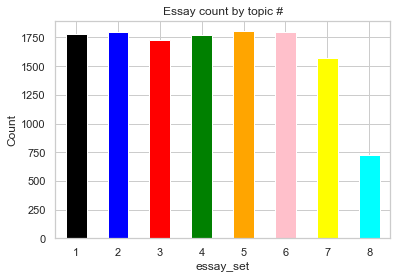

In [157]:
df.groupby('essay_set').agg('count').plot.bar(y='essay',color=['black', 'blue','red', 'green',"orange", "pink","yellow", 'cyan'], rot=0, legend=False)
plt.title('Essay count by topic #')
plt.ylabel('Count')
plt.show()

In [158]:
df.isnull().sum()

essay_id              0
essay_set             0
essay                 0
rater1_domain1        0
rater2_domain1        0
rater3_domain1    12848
domain1_score         0
rater1_domain2    11176
rater2_domain2    11176
domain2_score     11176
rater1_trait1     10684
rater1_trait2     10684
rater1_trait3     10684
rater1_trait4     10684
rater1_trait5     12253
rater1_trait6     12253
rater2_trait1     10684
rater2_trait2     10684
rater2_trait3     10684
rater2_trait4     10684
rater2_trait5     12253
rater2_trait6     12253
rater3_trait1     12848
rater3_trait2     12848
rater3_trait3     12848
rater3_trait4     12848
rater3_trait5     12848
rater3_trait6     12848
dtype: int64

In [159]:
cap = ['@CAPS'+str(i) for i in range(100)]
loc = ['@LOCATION'+str(i) for i in range(100)]
org =['@ORGANIZATION'+str(i) for i in range(100)]
per = ['@PERSON'+str(i) for i in range(100)]
date = ['@DATE'+str(i) for i in range(100)]
time = ['@TIME'+str(i) for i in range(100)]
money = ['@MONEY'+str(i) for i in range(100)]
ner =  cap + loc + org + per + date + time + money

# EDA

## Score

In [160]:
df.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
set1 = df[df['essay_set'] == 1]
set2 = df[df['essay_set'] == 2]
set3 = df[df['essay_set'] == 3]
set4 = df[df['essay_set'] == 4]
set5 = df[df['essay_set'] == 5]
set6 = df[df['essay_set'] == 6]
set7 = df[df['essay_set'] == 7]
set8 = df[df['essay_set'] == 8]

In [162]:
sett = [set1, set2, set3, set4, set5, set6, set7, set8]

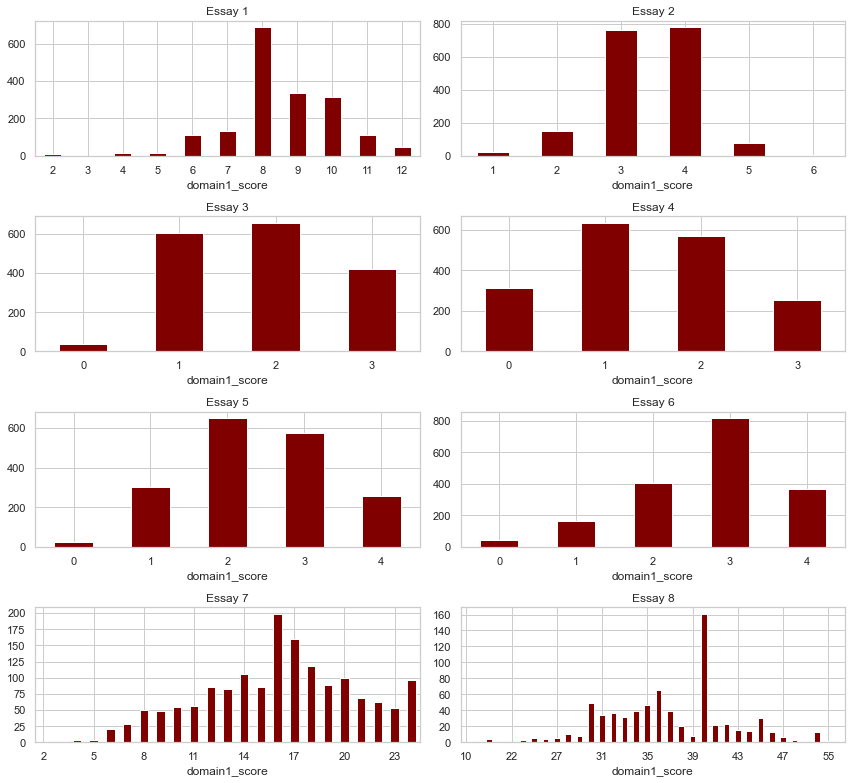

In [163]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(12,12), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        df[df['essay_set'] == topic_number].groupby('domain1_score')['essay_id'].agg('count').plot.bar(ax=ax[i, j], rot=0, color="maroon")
        ax[i,j].set_title('Essay %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

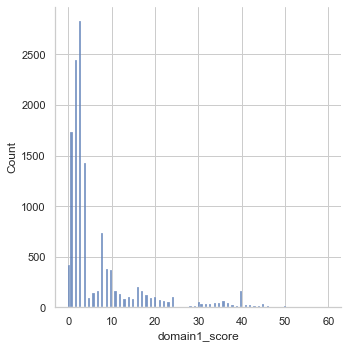

In [164]:
sns.displot(df['domain1_score'])
plt.show()

## Number of words of essays in each set

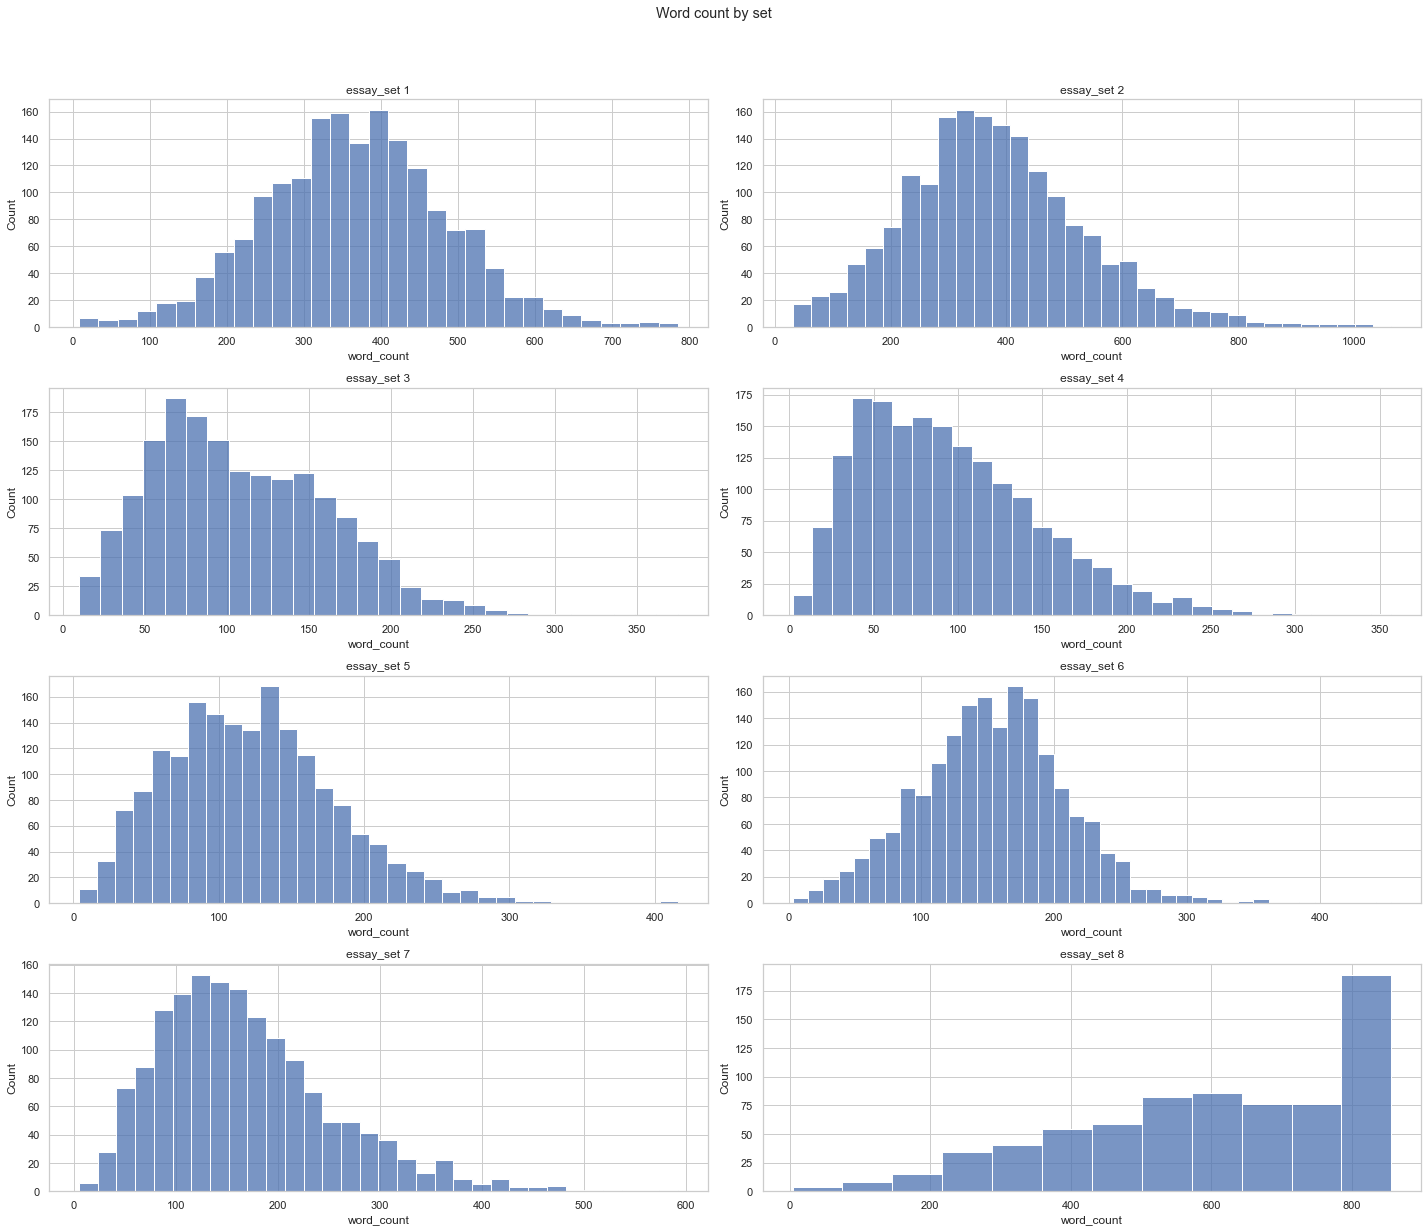

In [165]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(20, 18))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.histplot(data[data['essay_set'] == topic_number]['word_count'], ax=ax[i, j])
        ax[i,j].set_title('essay_set %i' % topic_number)

plt.suptitle('Word count by set')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

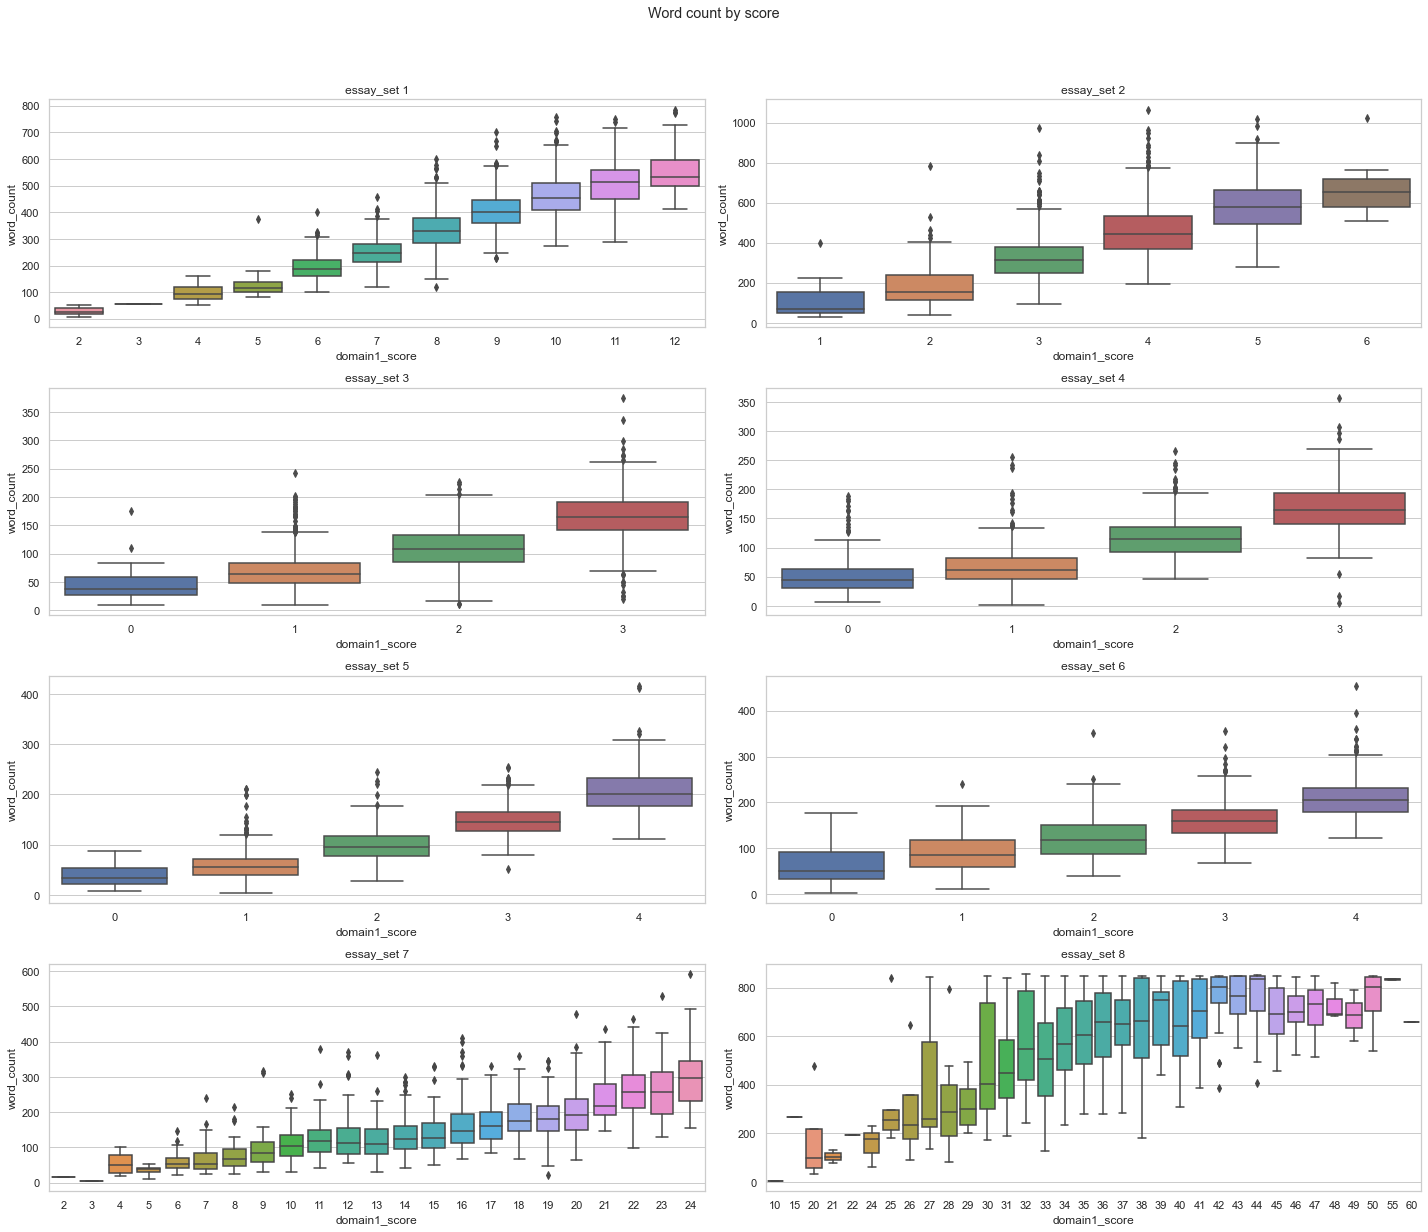

In [166]:
df['word_count'] = df['essay'].str.strip().str.split().str.len()
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(20, 18))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.boxplot(x='domain1_score', y='word_count', data=df[df['essay_set'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('essay_set %i' % topic_number)

plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [167]:
data = df.copy()
data = data[['essay_id', 'essay_set', 'essay', 'domain1_score', 'word_count']]
data.head()

,essay_id,essay_set,essay,domain1_score,word_count
0,1,1,"Dear local newspaper, I think effects computer...",8,338
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,419
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,279
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,524
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,465


### Remove outliers from set 1

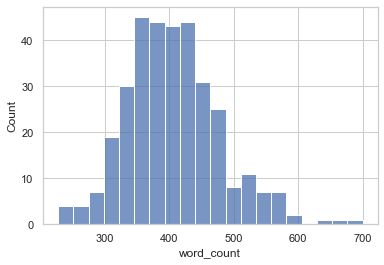

In [168]:
topic = data[data.essay_set == 1]
sns.histplot(topic[topic['domain1_score'] == 9]['word_count'])
plt.show()

In [169]:
temp = topic[(topic.domain1_score == 9) & (topic.word_count > 620)]
data = data[~data.isin(temp)].dropna()
data.head()

,essay_id,essay_set,essay,domain1_score,word_count
0,1.0,1.0,"Dear local newspaper, I think effects computer...",8.0,338.0
1,2.0,1.0,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,419.0
2,3.0,1.0,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,279.0
3,4.0,1.0,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,524.0
4,5.0,1.0,"Dear @LOCATION1, I know having computers has a...",8.0,465.0


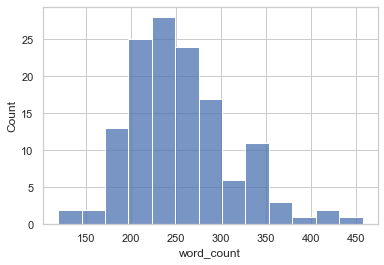

In [170]:
sns.histplot(topic[topic['domain1_score'] == 7]['word_count'])
plt.show()

In [171]:
temp = topic[(topic.domain1_score == 7) & ((topic.word_count < 150) | (topic.word_count > 350))]
temp
data = data[~data.isin(temp)].dropna()
data.head()

,essay_id,essay_set,essay,domain1_score,word_count
0,1.0,1.0,"Dear local newspaper, I think effects computer...",8.0,338.0
1,2.0,1.0,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,419.0
2,3.0,1.0,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,279.0
3,4.0,1.0,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,524.0
4,5.0,1.0,"Dear @LOCATION1, I know having computers has a...",8.0,465.0


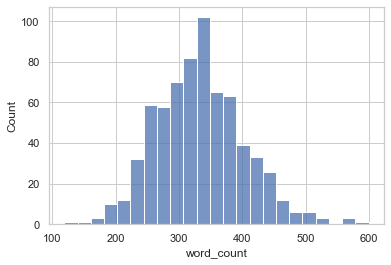

In [172]:
sns.histplot(topic[topic['domain1_score'] == 8]['word_count'])
plt.show()

In [180]:
temp = topic[(topic.domain1_score == 8) & ((topic.word_count < 180) | (topic.word_count > 570))]
# temp = topic[(topic.domain1_score == 8) & (topic.word_count < 180)]
temp
data = data[~data.isin(temp)].dropna()
data.head()

,essay_id,essay_set,essay,domain1_score,word_count
0,1.0,1.0,"Dear local newspaper, I think effects computer...",8.0,338.0
1,2.0,1.0,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,419.0
2,3.0,1.0,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,279.0
3,4.0,1.0,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,524.0
4,5.0,1.0,"Dear @LOCATION1, I know having computers has a...",8.0,465.0


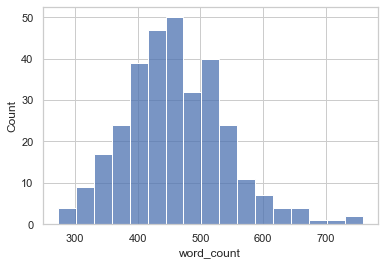

In [181]:
sns.histplot(topic[topic['domain1_score'] == 10]['word_count'])
plt.show()

## Remove outliers from set 2

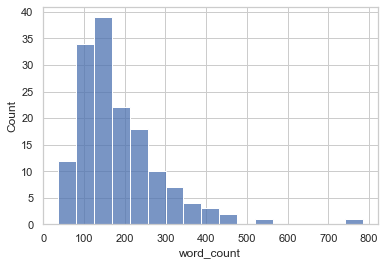

In [187]:
topic = data[data.essay_set == 2]
sns.histplot(topic[topic['domain1_score'] == 2]['word_count'])
plt.show()

In [188]:
temp = topic[topic['word_count'] > 500]
temp

,essay_id,essay_set,essay,domain1_score,word_count
1789,2984.0,2.0,How @CAPS4 you feel if your favorite book was ...,5.0,520.0
1790,2985.0,2.0,Do you think that you should be able to take c...,2.0,784.0
1799,2994.0,2.0,A lot of people that are in school have probab...,4.0,656.0
1806,3001.0,2.0,Books Removed From Shelves? 'All of us ca...,4.0,514.0
1825,3020.0,2.0,Do you want your nine year old @CAPS2 talking ...,4.0,729.0
...,...,...,...,...,...
3570,4765.0,2.0,Books are very important to our society. They ...,4.0,528.0
3571,4766.0,2.0,"In todays world, children are exposed to a lot...",5.0,652.0
3573,4768.0,2.0,"Books, movies, magazines, music, etc., make up...",3.0,546.0
3574,4769.0,2.0,I believe that certain materials should not be...,3.0,592.0


## plot score outlier

/Users/SonTungKieu/miniforge3/envs/tensorflow/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/SonTungKieu/miniforge3/envs/tensorflow/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/SonTungKieu/miniforge3/envs/tensorflow/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/SonTungKieu/miniforge3/envs/tensorflow/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/SonTungKieu/miniforge3/envs/tensorflow/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWar

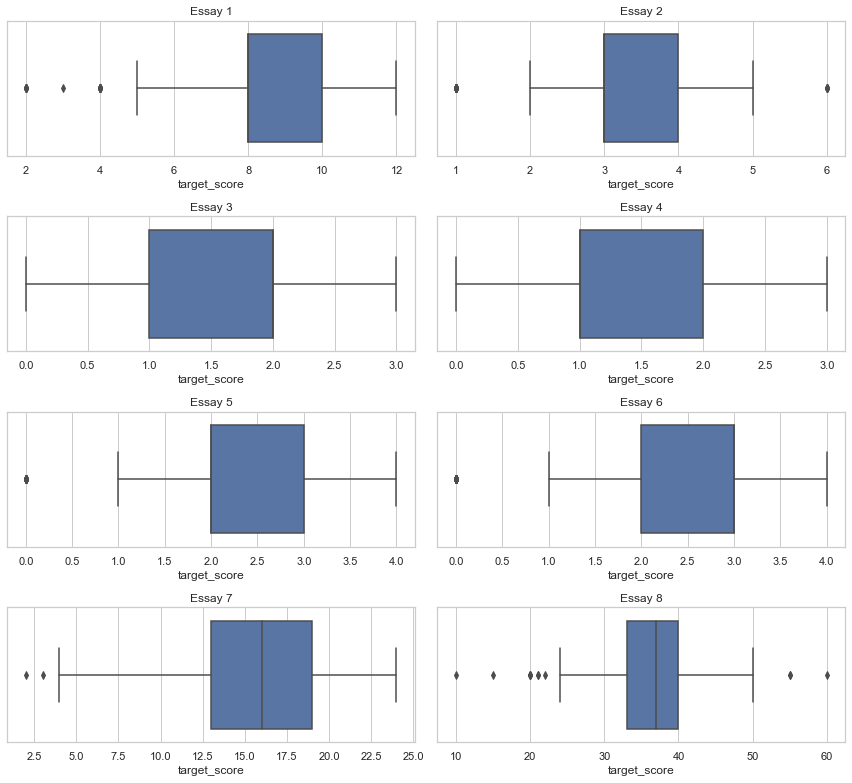

In [30]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(12,12), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.boxplot(x = 'target_score', data = df[df['topic'] == topic_number], orient='v', ax=ax[i,j])
        ax[i,j].set_title('Essay %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Check missing value

In [31]:
#check missing value
%matplotlib inline

def missing_values(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):

    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')

    plt.title('Missing values percentage per column', fontsize = 20, weight = 'bold' )

    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh + 12.5, f'Columns with more than {thresh}% missing values', fontsize = 12, color = 'crimson',
         ha = 'left' ,va = 'top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha = 'left' ,va = 'top')
    plt.xlabel('Columns', size = 15, weight = 'bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight = 'bold')

    return plt.show()

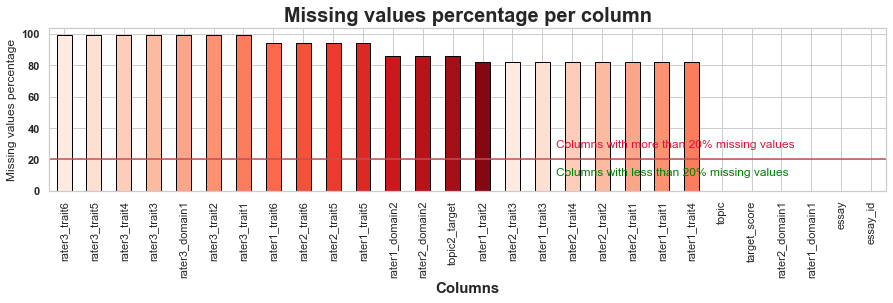

In [32]:
missing_values(df, thresh = 20, color = sns.color_palette('Reds',15))